# UCC Functions

## Overview

In this notebook, we will introduce the basic functions of the `UCC` class. We will use `UCCSD` as a typical example. Other classes such as `kUpCCGSD` share the same interface.

We will show that, along with nice high-level interface, the `UCC` class also offers great flexibility and allows users to easily build their own algorithms.

## Setup

In [1]:
from tencirchem import UCCSD
from tencirchem.molecule import h2

TenCirChem provides a set of molecules in the `molecule` module for debugging and fast-prototyping.

TenCirChem uses PySCF `Mole` object to handle molecules. In other words, custom molecules can be built with exact the same interface as PySCF.

In [2]:
h2

## Hello world

This cell illustrates a simple UCC calculation.

In [3]:
uccsd = UCCSD(h2)
uccsd.kernel()
uccsd.print_summary(include_circuit=True)

################################ Ansatz ###############################
 #qubits  #params  #excitations initial condition
       4        2             3               RHF
############################### Circuit ###############################
 #qubits  #gates  #CNOT  #multicontrol  depth #FLOP
       4      15     10              1      9  2160
############################### Energy ################################
       energy (Hartree)  error (mH) correlation energy (%)
HF            -1.116706   20.568268                 -0.000
MP2           -1.129868    7.406850                 63.989
CCSD          -1.137275   -0.000165                100.001
UCCSD         -1.137274    0.000000                100.000
FCI           -1.137274    0.000000                100.000
############################# Excitations #############################
     excitation configuration     parameter  initial guess
0        (3, 2)          1001  1.082849e-16       0.000000
1        (1, 0)          0110  1.082

UCC class has a convenient method `print_summary` for a quick glance of the calculation.
The summary contains 5 parts:

- Ansatz.
- Circuit. TenCirChem by default uses a compact circuit for excitations (see the Circuit section below), in which multi-control gates are involved. The circuit part also gives an estimation of the FLOP required for a full statevector simulation of the circuit.
- Energy. Includes optimized UCC energy along with HF, MP2, CCSD and FCI energy for reference. 
- Excitations. Includes optimized UCC parameters and their initial guess. See the documentation for the convention of excitation operators and configurations.
- Optimization Results. This is simply a modified SciPy `OptimizeResult` object.

`print_summary` by default will not print circuit information since it is sometimes significantly more time-consuming than other parts.

One may print different parts of the summary separately using corresponding standalone method such as `print_ansatz`.

## The Circuit

TenCirChem uses TensorCircuit `circuit` object for quantum circuit.

In [4]:
circuit = uccsd.get_circuit()
circuit

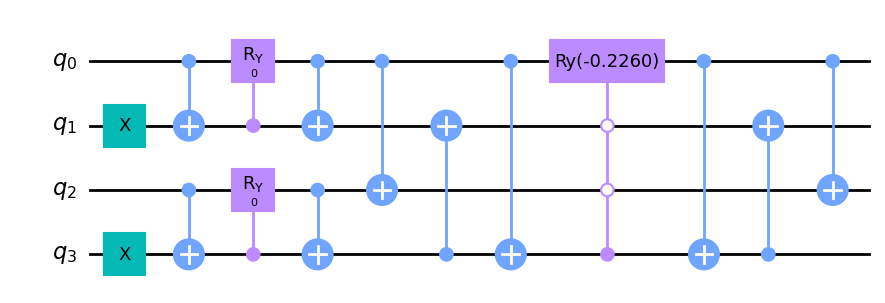

In [5]:
circuit.draw(output="mpl")

TenCirChem uses the compact circuit for excitations described in [https://arxiv.org/pdf/2005.14475.pdf](https://arxiv.org/pdf/2005.14475.pdf).
To decompose the multicontroled $R_y$ gate into elementary gates, use the `decompose_multicontrol` argument.

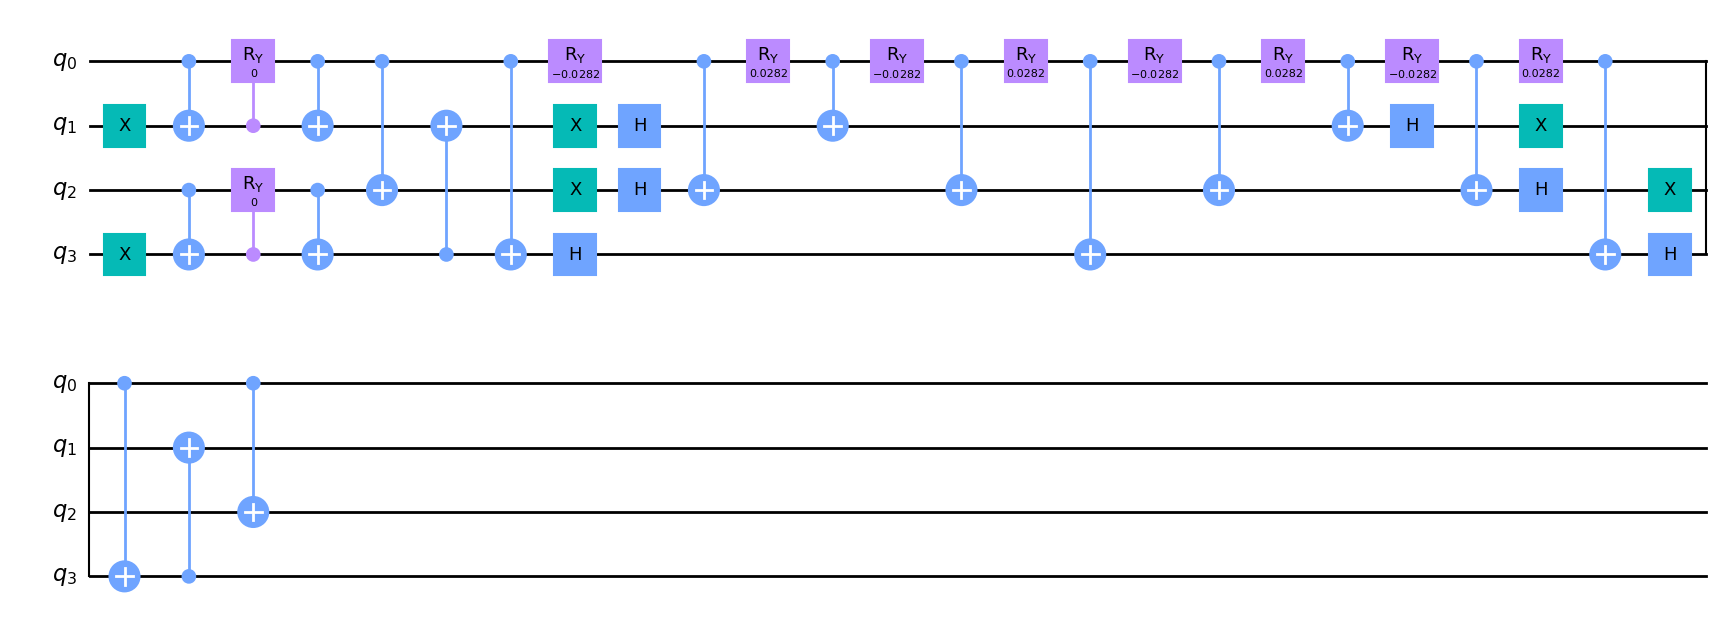

In [6]:
uccsd.get_circuit(decompose_multicontrol=True).draw(output="mpl")

For traditional Trotterized circuit, use the `trotter` argument.

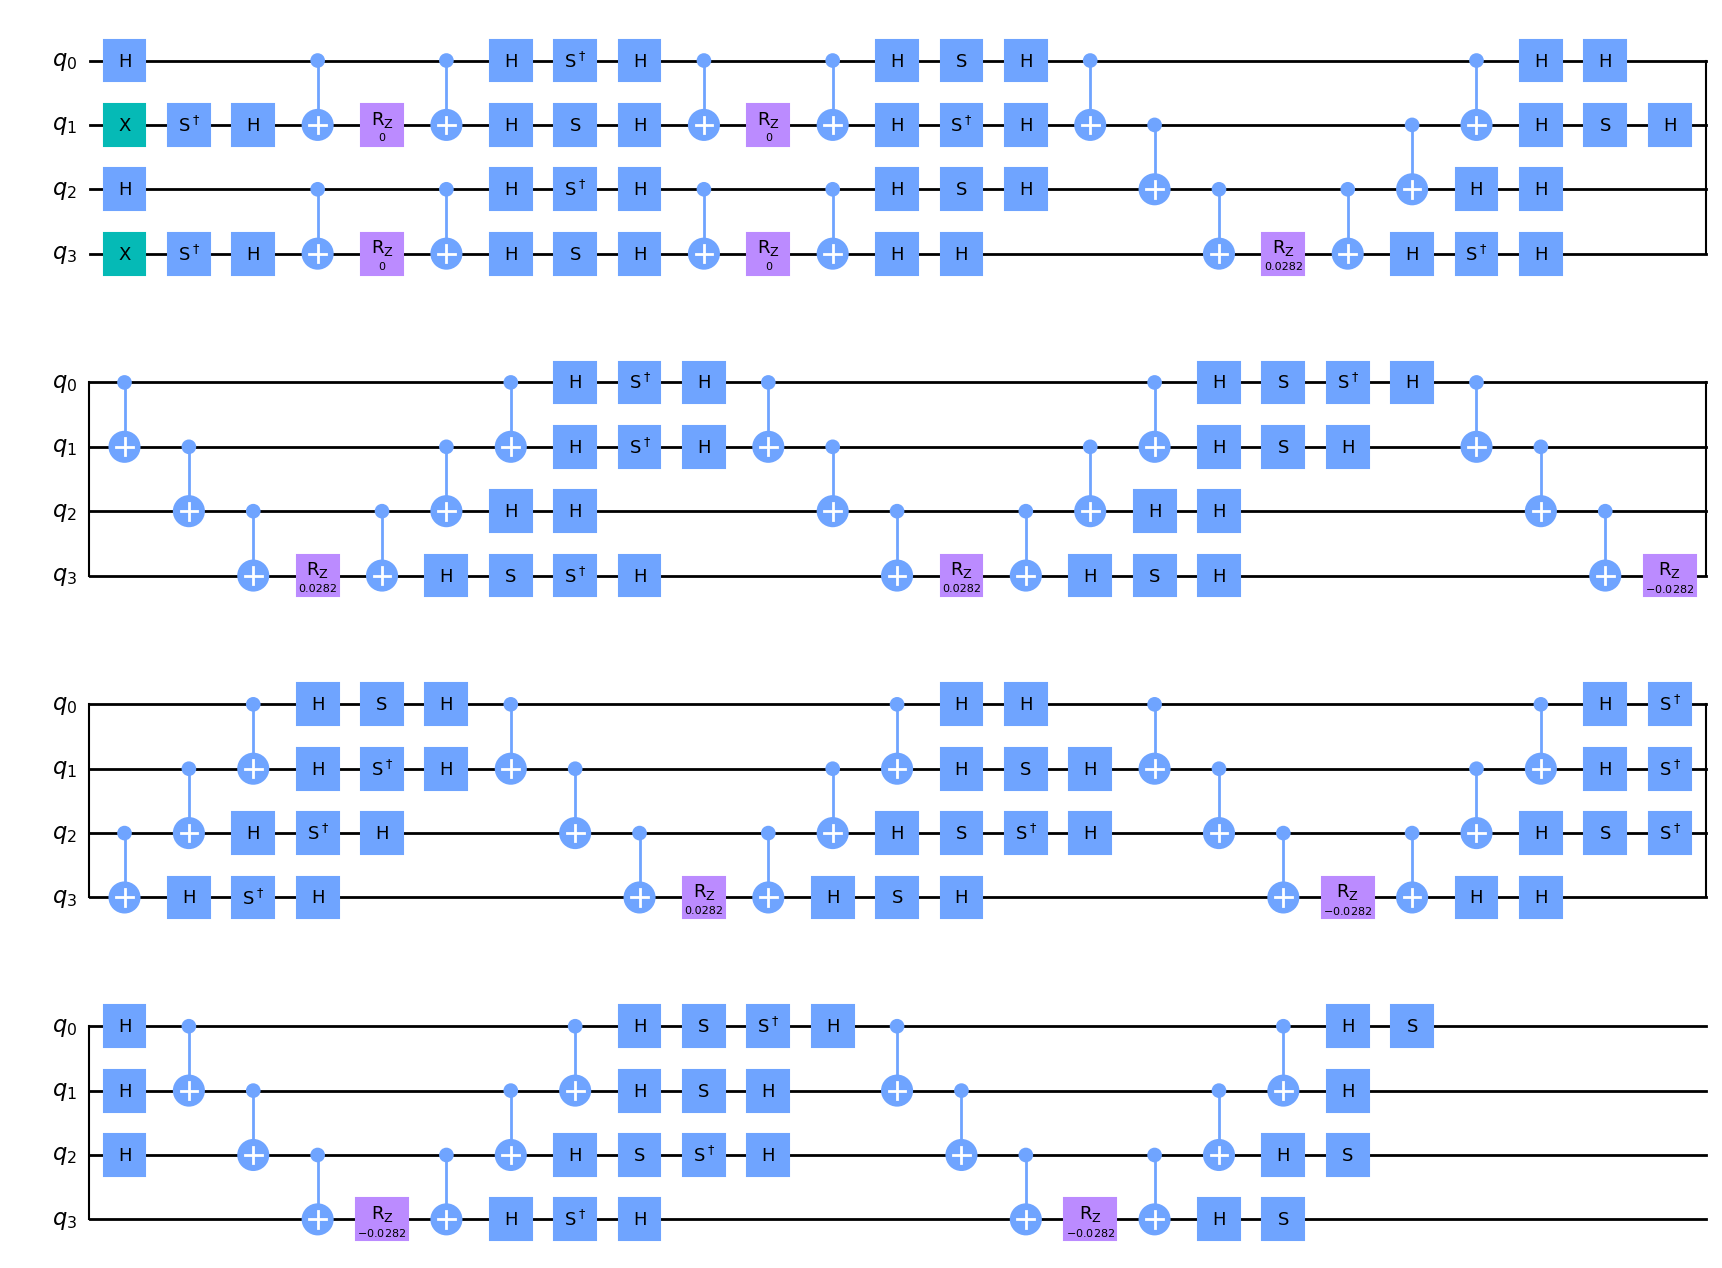

In [7]:
uccsd.get_circuit(trotter=True).draw(output="mpl")

## Useful Attributes
TenCirChem chooses to expose its internal data whenever possible and in the simplest way.
The intention is to make TenCirChem easy to hack and useful as a handy toolbox.

In [8]:
uccsd.n_qubits, uccsd.n_elec

(4, 2)

In [9]:
# PySCF objects
uccsd.mol, uccsd.hf

(<pyscf.gto.mole.Mole at 0x7f13232ed950>,
 <pyscf.scf.hf_symm.SymAdaptedRHF at 0x7f132bafc850>)

In [10]:
uccsd.e_hf, uccsd.e_mp2, uccsd.e_ccsd, uccsd.e_ucc, uccsd.e_fci, uccsd.e_nuc

(-1.116706137236105,
 -1.1298675557838804,
 -1.1372745709766439,
 -1.1372744055294384,
 -1.1372744055294384,
 0.7141392859919029)

In [11]:
# one and two electron integral in molecular orbital basis
uccsd.int1e.shape, uccsd.int2e.shape

((2, 2), (2, 2, 2, 2))

In [12]:
# Hamiltonian as openfermion FermionOperator
uccsd.h_fermion_op

0.7141392859919029 [] +
-1.2527052599711868 [0^ 0] +
-0.48227117798977825 [0^ 1^ 0 1] +
-0.6745650967143663 [0^ 2^ 0 2] +
-0.18126641677772592 [0^ 2^ 1 3] +
-0.6635375947675042 [0^ 3^ 0 3] +
-0.18126641677772592 [0^ 3^ 1 2] +
-0.47569770336145906 [1^ 1] +
-0.18126641677772592 [1^ 2^ 0 3] +
-0.6635375947675038 [1^ 2^ 1 2] +
-0.18126641677772592 [1^ 3^ 0 2] +
-0.6974673850129379 [1^ 3^ 1 3] +
-1.2527052599711868 [2^ 2] +
-0.48227117798977825 [2^ 3^ 2 3] +
-0.47569770336145906 [3^ 3]

In [13]:
# Hamiltonian as openfermion QubitOperator
uccsd.h_qubit_op

(-0.09835117053027564+0j) [] +
(0.04531660419443148+0j) [X0 X1 X2 X3] +
(0.04531660419443148+0j) [X0 X1 Y2 Y3] +
(0.04531660419443148+0j) [Y0 Y1 X2 X3] +
(0.04531660419443148+0j) [Y0 Y1 Y2 Y3] +
(-0.22297018776182556+0j) [Z0] +
(0.12056779449744456+0j) [Z0 Z1] +
(0.17436684625323448+0j) [Z0 Z2] +
(0.16588439869187604+0j) [Z0 Z3] +
(0.1712591626176813+0j) [Z1] +
(0.16588439869187596+0j) [Z1 Z2] +
(0.16864127417859157+0j) [Z1 Z3] +
(-0.22297018776182548+0j) [Z2] +
(0.12056779449744456+0j) [Z2 Z3] +
(0.1712591626176812+0j) [Z3]

In [14]:
# t1, t2 amplitude based on MP2 or CCSD (determined by the `init_method` argument)
uccsd.t1, uccsd.t2

(None, array([[[[-0.07260815]]]]))

In [15]:
# `param_ids` maps excitation operators to parameters.
# Some excitation operators share the same parameter due to symmetry
# refer to the documentation for the convention of excitation operators
uccsd.ex_ops, uccsd.param_ids, uccsd.init_guess

([(3, 2), (1, 0), (1, 3, 2, 0)], [0, 0, 1], [0.0, -0.07260814651571333])

In [16]:
# Scipy `OptimizeResult` object
uccsd.opt_res

            e: -1.1372744055294384
          fun: array(-1.13727441)
     hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
   init_guess: [0.0, -0.07260814651571333]
          jac: array([-9.60813938e-19, -1.11022302e-16])
      message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
         nfev: 6
          nit: 4
         njev: 6
     opt_time: 0.010929584503173828
 staging_time: 3.337860107421875e-06
       status: 0
      success: True
            x: array([ 1.08284918e-16, -1.12986561e-01])

In [17]:
# the optimized parameters
uccsd.params

array([ 1.08284918e-16, -1.12986561e-01])

In [18]:
# optimized circuit statevector
uccsd.statevector()

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  9.93623806e-01,  1.08284918e-16,  0.00000000e+00,
        0.00000000e+00,  1.08284918e-16, -1.12746318e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [19]:
# configuration interaction vector
uccsd.civector()

array([ 9.93623806e-01,  1.08284918e-16,  1.08284918e-16, -1.12746318e-01])

In [20]:
# bitstring for each element in the CI vector
uccsd.get_ci_strings()

array([ 5,  6,  9, 10], dtype=uint64)

## Active Space Approximation

TenCirChem offers the simplest API for active space approximation among available packages.

In [21]:
from tencirchem.molecule import h8

# (2e, 2o) active space
uccsd = UCCSD(h8, active_space=(2, 2))
uccsd.kernel()
uccsd.print_summary()

################################ Ansatz ###############################
 #qubits  #params  #excitations initial condition
       4        2             3               RHF
############################### Energy ################################
       energy (Hartree)    error (mH) correlation energy (%)
HF            -4.149619  1.343542e+01                 -0.000
MP2           -4.157573  5.480558e+00                 59.208
CCSD          -4.163054 -1.932076e-04                100.001
UCCSD         -4.163054 -8.881784e-13                100.000
FCI           -4.163054  0.000000e+00                100.000
############################# Excitations #############################
     excitation configuration     parameter  initial guess
0        (3, 2)          1001  1.112312e-15       0.000000
1        (1, 0)          0110  1.112312e-15       0.000000
2  (1, 3, 2, 0)          1010 -1.377274e-01      -0.082065
######################### Optimization Result #########################
          

The reference energies including MP2, CCSD nad FCI are also based on the active space.

## Starting from the Integrals
One may start the UCC calculation from custom integrals without the need to define a molecule.

In [22]:
uccsd_from_integral = UCCSD.from_integral(uccsd.int1e, uccsd.int2e, uccsd.n_elec, uccsd.e_core)
# the energy is the same with the last calculation
print(uccsd_from_integral.kernel(), uccsd.e_ucc)

-4.163053957291894 -4.163053957291894


## Feeding in Custom Parameters

In TenCirChem, it is also fairly easy to feed in customized parameters to get desired properties

In [23]:
import numpy as np

params = np.zeros(uccsd.n_params)

In [24]:
uccsd.energy(params), uccsd.e_hf

(-4.149618533807672, -4.1496185338076685)

In [25]:
# energy and gradient, can be used in optimization
# one caveat is that TenCirChem by default uses float32, while SciPy assumes float64
uccsd.energy_and_grad(params)

(-4.149618533807672, array([-2.27679890e-15,  1.93866451e-01]))

In [26]:
uccsd.statevector(params)

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [27]:
# Configuration Interaction vector. Compatible with PySCF.
civector = uccsd.civector(params)
civector

array([1., 0., 0., 0.])

In [28]:
# calculate the energy by hand
civector @ uccsd.hamiltonian(civector) + uccsd.e_core

-4.149618533807672

In [29]:
# set the parameters, and use the class as usual
uccsd.params = params
uccsd.print_summary()

################################ Ansatz ###############################
 #qubits  #params  #excitations initial condition
       4        2             3               RHF
############################### Energy ################################
       energy (Hartree)  error (mH) correlation energy (%)
HF            -4.149619   13.435423                 -0.000
MP2           -4.157573    5.480558                 59.208
CCSD          -4.163054   -0.000193                100.001
UCCSD         -4.149619   13.435423                  0.000
FCI           -4.163054    0.000000                100.000
############################# Excitations #############################
     excitation configuration  parameter  initial guess
0        (3, 2)          1001        0.0       0.000000
1        (1, 0)          0110        0.0       0.000000
2  (1, 3, 2, 0)          1010        0.0      -0.082065
######################### Optimization Result #########################
            e: -4.163053957291894


## Reduced Density Matrix
Calculate reduced density matrix in atomic orbital or molecule orbital basis 

In [30]:
uccsd.make_rdm1().shape, uccsd.make_rdm2().shape

((8, 8), (8, 8, 8, 8))

In [31]:
uccsd.make_rdm1(basis="MO").shape, uccsd.make_rdm2(basis="MO").shape

((8, 8), (8, 8, 8, 8))

Note that the RDM is for the whole space, beyond the active space.